# Reinforcement Learning Using OpenAI Gym

## Quick Introduction to RL (Reinforcement Learning)

Reinforcement learning (RL) is an area of machine learning concerned with how software agents ought to take actions in an environment so as to maximize some notion of cumulative reward. Reinforcement learning is one of three basic machine learning paradigms, alongside supervised learning and unsupervised learning.

It differs from supervised learning in that labelled input/output pairs need not be presented, and sub-optimal actions need not be explicitly corrected. Instead the focus is finding a balance between exploration (of uncharted territory) and exploitation (of current knowledge).

The environment is typically formulated as a Markov decision process (MDP), as many reinforcement learning algorithms for this context utilize dynamic programming techniques. The main difference between the classical dynamic programming methods and reinforcement learning algorithms is that the latter do not assume knowledge of an exact mathematical model of the MDP and they target large MDPs where exact methods become infeasible.

**source**: https://en.wikipedia.org/wiki/Reinforcement_learning

## Experiments with OpenAI Gym

Gym is a toolkit for developing and comparing reinforcement learning algorithms. It makes no assumptions about the structure of your agent, and is compatible with any numerical computation library, such as TensorFlow or Theano.

The gym library is a collection of test problems — environments — that you can use to work out your reinforcement learning algorithms. These environments have a shared interface, allowing you to write general algorithms.

**source**: https://gym.openai.com/docs/

## Learn by doing -- A reinforcement learning experiment using OpenAI Gym

### Creating a Gym environment

To start using OpenAI Gym, one must install it and import it into a Python environment. One can either use a pre-made environment for testing, or build their own.

For this experiment, I will be using the pre-built 'CartPole' environment. The state consists of the cart's position and velocity, and the pole's angle and velocity. The actions are applying a force of +1 or -1 to the cart. The goal is to keep the pole balanced for 500 game steps. The reward is 1 on each step for as long as the pole is balanced.

We can view the action and observation space as follows.

In [2]:
import gym

env = gym.make("CartPole-v1")
observation = env.reset()

print(f"Action Space Shape: {env.action_space}")
print(f"Action Example: {env.action_space.sample()}")

print(f"Observation Space Shape: {env.observation_space}")
print(f"Observation Example: {observation}")

Action Space Shape: Discrete(2)
Action Example: 1
Observation Space Shape: Box(4,)
Observation Example: [ 0.0132411   0.0352145  -0.028805   -0.01244701]


We can also render the environment, until an episode completes, as follows.

In [3]:
# Enables recording
# import gym
# from gym.wrappers import Monitor
# env = gym.make("Acrobot-v1")
# env = Monitor(env, './video')

env.reset()
done = False

while not done:
  env.render()
  action = env.action_space.sample()
  observation, reward, done, info = env.step(action)

env.close()

In the prior code block, we take random actions and only utilize the `done` information to determine if a session has finished. You can either run the code to see the animation for youself, or view the video below.

<video height="320" controls src="assets/cartpole_random.mp4" style="display: block;margin-left: auto;margin-right: auto;"/>

## Building a smarter agent with reinforcement learning and tabular methods

Tabular methods use arrays and tables to hold an approximate of the value functions. More simply, they store every combination of state/action pairs and hold a perceived value of that pair. This simplifies the learning process because tables are very quick to compute and can give decent results given the state and action spaces are small enough. One can also reduce the size of the state and action spaces to make the agent learn evey quicker due to a smaller table to fill (at the cost of a reduced accuracy). One idea that can be implemented, that I will not use in the Acrobot example, is to transform state values before binning them. For example, one could use a sigmoid function to spread the state values out so that the center distrubtion gets put into more bins while the outliers get grouped together.

To apply a tabular method to this CartPole example, we simply need a table that holds every possible state/action pair. Due to the size of this table, I bin the state values into 20 buckets so that there are 2 * 4^20 values to compute. I also add a randomness factor to force my agent to explore more in the beginning then slowly exploit more as it learns. Feel free to edit the global variables (hyperparameters) to see what happens. This tabular method is also very random in how well it does with a small amount of sessions.

In [1]:
# Configuration Values and Imports

import gym

env = gym.make("CartPole-v1")

import matplotlib.pyplot as plt
import math
import numpy as np
import random

RENDER_STEPS = 250
SESSIONS = 500

BINS = 20
REWARD_DISCOUNT = 0.98
LEARNING_RATE_DECAY = 0.995
LEARNING_RATE_MIN = 0.150
EXPLORATION_RATE = 1.0
EXPLORATION_RATE_DECAY = 0.975
EXPLORTATION_RATE_MIN = 0.005

BUFFER_SIZE = 20

In [2]:
# Include a plotting class to show results :]

class Plotter:
    def __init__(self):
        self._x_values = []
        self._y_values = []

    def add_plot_pair(self, x, y):
        self._x_values.append(x)
        self._y_values.append(y)

    def plot(self):
        plt.plot(self._x_values, self._y_values)
        plt.show()

    def plot_and_save(self, file_name):
        plt.plot(self._x_values, self._y_values)
        plt.savefig(file_name)

    def plot_smooth_graph(self, averaging_filter_length=100):
        if averaging_filter_length > len(self._x_values):
            self.plot()
            return

        rolling_average = []
        for index in range(len(self._x_values)):
            min_index = index - (averaging_filter_length / 2)
            min_index = int(0 if min_index < 0 else min_index)
            max_index = index + (averaging_filter_length / 2)
            max_index = int(
                len(self._x_values) - 1
                if max_index >= len(self._x_values)
                else max_index
            )

            rolling_average.append(
                sum(self._y_values[min_index:max_index]) // (max_index - min_index)
            )

        plt.title("Steps Achieved Per Session Over Training Duration")
        plt.xlabel("Sessions")
        plt.ylabel("Steps Achieved Per Session")
        plt.plot(
            self._x_values,
            rolling_average,
            color="#ade6bb",
            linewidth=2.5,
            label=f"Running Average of {averaging_filter_length} Sessions",
        )
        plt.plot(
            self._x_values,
            self._y_values,
            color="#e6add8",
            linewidth=0.25,
            label=f"Raw Steps Achieved",
        )
        plt.show()

In [3]:
# Some selective replay experience

class ReplayExperience:
    def __init__(self, buffer_size):
        self._buffer = []
        self._buffer_size = buffer_size
        self._forgetfullness = 0.15

    def get_experience(self):
        return random.choice(self._buffer)[1]

    def make_experience(self, value, experience):
        if len(self._buffer) < self._buffer_size:
            self._buffer.append((value, experience))
            return

        if np.random.rand() <= self._forgetfullness:
            del self._buffer[np.random.randint(len(self._buffer))]

        # Find the worst memory and replace it
        min_value = value
        min_index = -1
        for index in range(len(self._buffer)):
            if self._buffer[index][0] < min_value:
                min_value = self._buffer[index][0]
                min_index = index
        if min_index != -1:
            self._buffer[min_index] = (value, experience)


In [4]:
# Main table class that includes data normalization using sigmoids

class Table:
    def __init__(
        self,
        action_space,
        observation_space,
        bins,
        reward_dicount,
        exploration_rate,
        exploration_rate_min,
        exploration_rate_decay,
        learning_rate_min,
        learning_rate_decay,
    ):
        self._action_space = action_space
        self._observation_space = observation_space
        self._bins = bins
        self._reward_discount = reward_dicount
        self._exploration_rate = exploration_rate
        self._exploration_rate_min = exploration_rate_min
        self._exploration_rate_decay = exploration_rate_decay
        self._learning_rates = np.ones(
            (bins ** observation_space.shape[0], action_space.n)
        )
        self._learning_rate_min = learning_rate_min
        self._learning_rate_decay = learning_rate_decay

        self._table = np.zeros((bins ** observation_space.shape[0], action_space.n))

    def act(self, observation):
        observation = self._scale_observation(observation)
        bin = self._bin_observation(observation)

        if np.random.rand() <= self._exploration_rate:
            return self._action_space.sample()

        return np.argmax(self._table[bin])

    def learn_from_experience(self, experience):
        penalty = -sum(step[2] for step in experience)
        experience_length = len(experience)
        discount = self._reward_discount

        for index in range(experience_length - 1, 0, -1):
            observation, action, _ = experience[index]
            observation = self._scale_observation(observation)
            bin = self._bin_observation(observation)

            self._table[bin][action] += (
                self._learning_rates[bin][action] * discount * penalty
            )

            discount *= self._reward_discount
            self._update_learning_rate(bin, action)

        self._update_exploration_rate()

    def _update_learning_rate(self, bin, action):
        self._learning_rates[bin][action] *= self._learning_rate_decay
        self._learning_rates[bin][action] = max(
            self._learning_rate_min, self._learning_rates[bin][action]
        )

    def _update_exploration_rate(self):
        self._exploration_rate *= self._exploration_rate_decay
        self._exploration_rate = max(self._exploration_rate_min, self._exploration_rate)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _scale_observation(self, observation):
        scaled_observation = []

        for index in range(len(self._observation_space.low)):
            high = self._sigmoid(self._observation_space.high[index])
            low = self._sigmoid(self._observation_space.low[index])

            scaled_value = self._sigmoid(observation[index])
            scaled_value = (scaled_value - low) / (high - low)
            normalized_value = scaled_value * self._bins

            scaled_observation.append(int(normalized_value))

        return scaled_observation

    def _bin_observation(self, observation):
        bin = 0
        for index in range(len(observation)):
            bin += (2 ** index) * observation[index]
        return int(bin)  # must be an int since it is used as an index

In [5]:
# Creating objects before training starts

plotter = Plotter()
replay_experience = ReplayExperience(BUFFER_SIZE)
table = Table(
    env.action_space,
    env.observation_space,
    BINS,
    REWARD_DISCOUNT,
    EXPLORATION_RATE,
    EXPLORTATION_RATE_MIN,
    EXPLORATION_RATE_DECAY,
    LEARNING_RATE_MIN,
    LEARNING_RATE_DECAY,
)

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


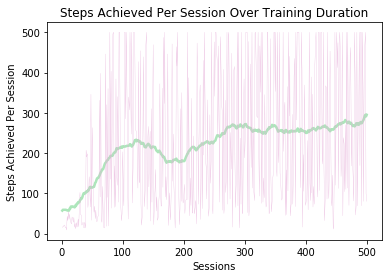

In [6]:
# Training

for session in range(1, SESSIONS + 1):  # offset by 1 for better formatting in results
    done = False
    step = 0
    experience = []

    observation = env.reset()

    while not done:

        if session % RENDER_STEPS == 1:
            env.render()
        step += 1

        action = table.act(observation)
        observation, reward, done, _ = env.step(action)

        experience.append((observation, action, reward))

    table.learn_from_experience(experience)
    replay_experience.make_experience(step, experience)
    experience = replay_experience.get_experience()
    table.learn_from_experience(experience)

    # print(f"Session {session} took {step} steps.")  -- prints too much in Jupyter
    plotter.add_plot_pair(session, step)

env.close()
plotter.plot_smooth_graph()

Once again, if you do not wish to run the code, some results are shown below. Unfortunatly, the graph does not show the legend; the green line shows a running average of 100 sessions while the light pink line shows the actual values at each session.

<img height="320" src="assets/cartpole_figure.png" style="display: block;margin-left: auto;margin-right: auto;"/>

<video height="320" controls src="assets/cartpole_trained.mp4" style="display: block;margin-left: auto;margin-right: auto;"/>